# Training a CNN on MNIST


## Step 1: Setting Up the Environment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F # Import F for functional calls like relu

# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations for the training and test data
# ToTensor converts images to PyTorch tensors
# Normalize adjusts pixel values to a range around 0 (here, -1 to 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # MNIST is grayscale, so one channel
])

# Download and load the training data
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# Download and load the test data
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create data loaders to iterate over datasets in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 79.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 45.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 44.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.81MB/s]


## Step 2: Defining the CNN Model


In [ ]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        # First convolutional layer: 1 input channel (grayscale), 32 output channels, 3x3 kernel, padding 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel, padding 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer: 2x2 kernel, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer 1: Input features calculated from conv/pool output (64 channels * 7x7 image size)
        # MNIST images are 28x28. After conv1 (no size change due to padding), pool1 (14x14).
        # After conv2 (no size change), pool2 (7x7). So, 64 * 7 * 7 features.
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Fully connected layer 2 (output layer): 128 input features, 10 output features (for 10 digits)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply conv1, then ReLU activation, then pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply conv2, then ReLU activation, then pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 7 * 7) # Reshape to (batch_size, features)
        # Apply fc1, then ReLU activation
        x = F.relu(self.fc1(x))
        # Apply fc2 (no activation here, CrossEntropyLoss will apply softmax)
        x = self.fc2(x)
        return x


## Step 3: Instantiating the Model, Loss Function, and Optimizer


In [ ]:
# Instantiate the model and move it to the selected device
model = MNISTCNN().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Step 4: Training the CNN


In [ ]:
epochs = 5
model.train() # Set the model to training mode

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to the selected device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

Epoch 1/5, Loss: 0.1624
Epoch 2/5, Loss: 0.0459
Epoch 3/5, Loss: 0.0324
Epoch 4/5, Loss: 0.0241
Epoch 5/5, Loss: 0.0175
Finished Training


# Evaluating the CNN and Visualizing Predictions


## Step 1: Setting Up for Evaluation


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# torchvision.transforms might be needed if your dataset doesn't directly output tensors
# from torchvision import transforms

## Step 2: Evaluating the CNN on Test Data


In [ ]:
model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations during inference
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)  # Move labels to the same device for comparison

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU before converting to NumPy
        all_labels.extend(labels.cpu().numpy())    # Move labels to CPU before converting to NumPy

if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
else:
    print('Test loader is empty. Cannot calculate accuracy.')
    accuracy = 0

# Convert lists to numpy arrays for easier use with scikit-learn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Accuracy of the model on the test images: 99.13%


## Step 3: Understanding Prediction Errors


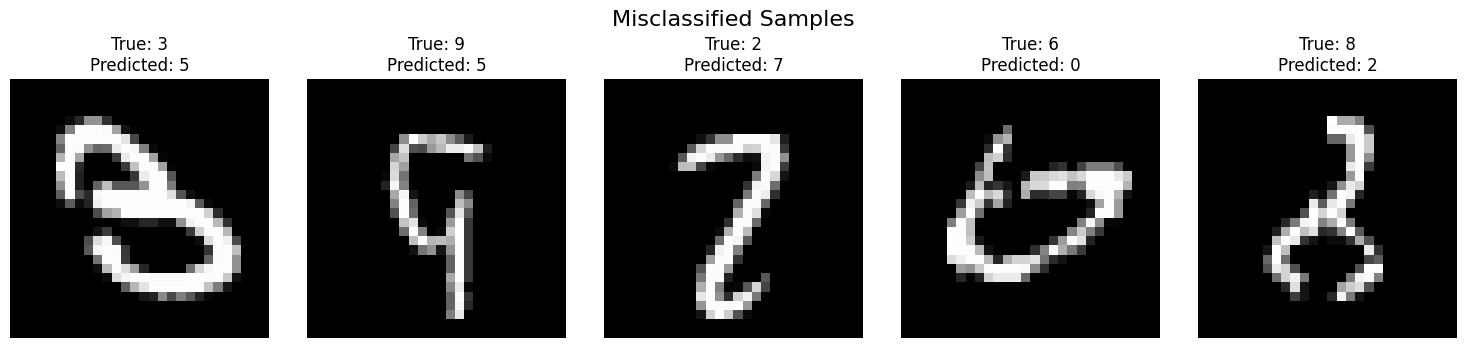

In [ ]:
# Identify misclassified samples
misclassified_mask = all_preds != all_labels
misclassified_indices = np.where(misclassified_mask)[0]

# Display a few misclassified images
num_misclassified_to_show = min(len(misclassified_indices), 5) # Show up to 5

if num_misclassified_to_show > 0:
    actual_indices_to_show = misclassified_indices[:num_misclassified_to_show]

    fig, axes = plt.subplots(1, num_misclassified_to_show, figsize=(num_misclassified_to_show * 3, 3.5))
    if num_misclassified_to_show == 1: # Ensure axes is iterable even for a single plot
        axes = [axes]
    fig.suptitle("Misclassified Samples", fontsize=16)

    for i, data_idx in enumerate(actual_indices_to_show):
        img_tensor, true_label_from_dataset = test_loader.dataset[data_idx]

        # Ensure img_tensor is a PyTorch tensor on CPU for display
        if not isinstance(img_tensor, torch.Tensor):
            # This basic conversion assumes PIL Image or HWC/HW numpy array
            # You might need more specific handling depending on your dataset's __getitem__
            from torchvision import transforms
            img_tensor = transforms.ToTensor()(img_tensor)

        img_display = img_tensor.cpu().squeeze().numpy()

        # Handle cases where image might still have 3 channels but is grayscale (e.g. shape (3, H, W))
        if img_display.ndim == 3 and img_display.shape[0] in [1, 3]: # C, H, W
             if img_display.shape[0] == 3: # If 3 channels, move channel to last dim for imshow
                 img_display = np.transpose(img_display, (1, 2, 0))
             else: # If 1 channel, squeeze it
                 img_display = img_display.squeeze(0)


        axes[i].imshow(img_display, cmap='gray' if img_display.ndim == 2 or img_display.shape[-1] == 1 else None)
        axes[i].set_title(f"True: {all_labels[data_idx]}\nPredicted: {all_preds[data_idx]}")
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
    plt.show()
else:
    print("No misclassified samples to display or all_preds/all_labels are not aligned with dataset.")

## Step 4: Visualizing Correct Predictions


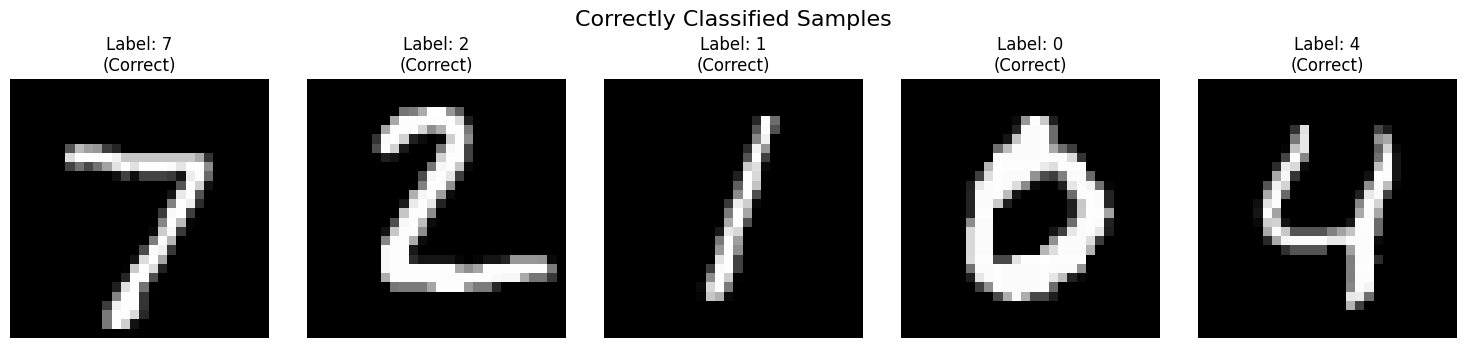

In [ ]:
# Identify correctly classified samples
correct_mask = all_preds == all_labels
correct_indices = np.where(correct_mask)[0]

# Display a few correctly classified images
num_correct_to_show = min(len(correct_indices), 5) # Show up to 5

if num_correct_to_show > 0:
    actual_indices_to_show = correct_indices[:num_correct_to_show]

    fig, axes = plt.subplots(1, num_correct_to_show, figsize=(num_correct_to_show * 3, 3.5))
    if num_correct_to_show == 1: # Ensure axes is iterable
        axes = [axes]
    fig.suptitle("Correctly Classified Samples", fontsize=16)

    for i, data_idx in enumerate(actual_indices_to_show):
        img_tensor, true_label_from_dataset = test_loader.dataset[data_idx]

        if not isinstance(img_tensor, torch.Tensor):
            from torchvision import transforms
            img_tensor = transforms.ToTensor()(img_tensor)

        img_display = img_tensor.cpu().squeeze().numpy()

        if img_display.ndim == 3 and img_display.shape[0] in [1, 3]:
             if img_display.shape[0] == 3:
                 img_display = np.transpose(img_display, (1, 2, 0))
             else:
                 img_display = img_display.squeeze(0)

        axes[i].imshow(img_display, cmap='gray' if img_display.ndim == 2 or img_display.shape[-1] == 1 else None)
        axes[i].set_title(f"Label: {all_labels[data_idx]}\n(Correct)")
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No correctly classified samples to display or all_preds/all_labels are not aligned with dataset.")

## Step 5: Recording and Interpreting Performance Metrics



Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.99      0.99      0.99       980
     1 - one       1.00      0.99      1.00      1135
     2 - two       0.99      0.99      0.99      1032
   3 - three       0.98      1.00      0.99      1010
    4 - four       0.99      0.99      0.99       982
    5 - five       0.98      0.99      0.99       892
     6 - six       0.99      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       1.00      0.98      0.99       974
    9 - nine       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Confusion Matrix:


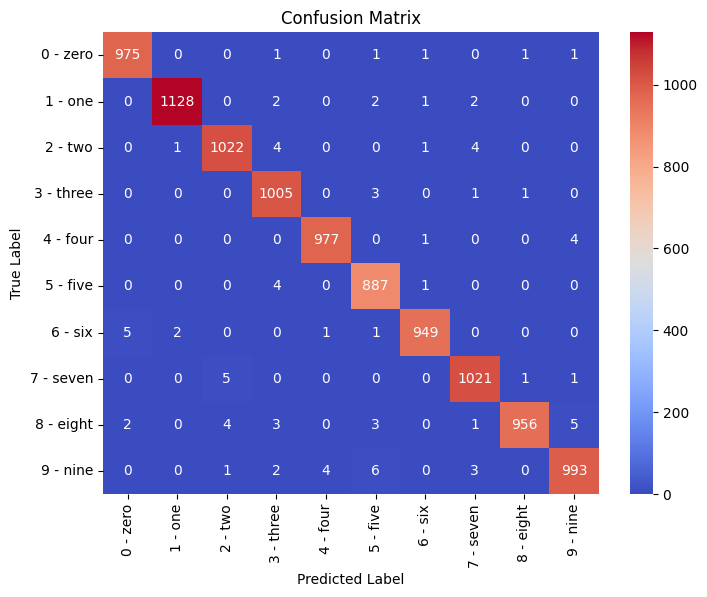

In [ ]:
# Ensure there are predictions to report on
if len(all_labels) > 0 and len(all_preds) > 0:
    # Classification Report
    print("\nClassification Report:")
    # Assuming class names might be available, e.g., from test_loader.dataset.classes
    # If not, integer labels will be used.
    try:
        class_names = test_loader.dataset.classes
        # Ensure class_names has the right number of elements if using numbers as names
        # Or generate generic names if dataset.classes doesn't exist or is unsuitable
        if len(class_names) != len(np.unique(all_labels)): # Basic check
             print("Warning: Number of class names doesn't match unique labels. Using numeric labels.")
             target_names_for_report = [str(c) for c in np.unique(all_labels)]
        else:
             target_names_for_report = [str(c) for c in class_names] # Ensure they are strings
    except AttributeError:
        print("`test_loader.dataset.classes` not found. Using unique numeric labels as target names.")
        # Generate target names based on unique labels present in all_labels
        unique_labels = np.unique(all_labels)
        target_names_for_report = [f"Class {l}" for l in unique_labels]

    print(classification_report(all_labels, all_preds, target_names=target_names_for_report, zero_division=0))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    confusion_mtx = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=target_names_for_report, yticklabels=target_names_for_report)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("No predictions available to generate classification report or confusion matrix.")